# Convergência do processo de minimização

O arquivo padrão de saída **fort.220** contém informações sobre a convergência do processo de minimização em cada loop interno (*inner loop*: iteração de minimização) executado pelo GSI. Com os dados deste arquivo é possível analisar a contribuição de diferentes observações na função custo (`J`) em relação ao custo total (`cost`). Informações sobre a norma/produto interno dos gradientes (`grad`), stepsize e indicação da nova direção de busca (`b`) do método dos gradientes conjugados também são fornecidas. Mais informações sobre os dados fornecidos pelo arquivo **fort.220** estão disponíveis nos guias do GSI: User’s Guide Version v3.7 (seção 4.6) e Advanced User’s Guide v3.5 (seção 3.1).


## Leitura do arquivo **fort.220** 

Para leitura do arquivo **fort.220** foram elaboradas as funções dentro da classe `read_diag`:

1. `fort_220_cost_gradient(DIRdiag, dates)`: esta função lê todas as linhas do arquvio fort.220 e identifica as linhas com as expressões `Minimization iteration`, `costterms Jb,Jo,Jc,Jl  =` e `cost,grad,step,b,step? =`. Utilizando os valores de cada variável (identificada por `Label`) são constuídos dois dataframes (duas tabelas) onde as colunas são, na ordem, as variáveis `'InnerLoop', 'Jb', 'Jo', 'Jc', 'Jl', 'cost', 'grad', 'step', 'b' e 'step?'`. O primeiro dataframe corresponde aos valores de cada variável nas iterações internas (*inner loop*) do **1º outer loop** e o segundo dataframe contém os valores das variáveis em cada iteração interna do **2º outer loop**. No final a função concatena as tabelas formando uma lista bidimensional de tabelas com relação ao tempo (range de datas) e outer loops (1º ou 2º).

**Exemplo:** pedaço de uma tabela do **1º outer loop**. 

|     |	InnerLoop |	Jb    |	Jo   |	Jc  |	Jl |	cost |	grad |	step |	b   |	step? |
|:--- |:---:      |:---:  |:---: |:---: |:---: |:---:    |:---:  |:---:  |:---: |---:     |
|0 |	0 |	0.000000 |	872614.730155 |	0.000000 |	0.000000e+00 |	872614.730155 |	116.153929 |	0.650383 |	0.000000 |	good |
|1 |	1 |	1023.257157 |	862816.657900 |	0.019797 |	2.893432e-07 |	863839.934854 |	71.176122 |	3.941374 |	0.375492 |	good |
|2 |	2 |	5344.739506 |	838526.699901 |	1.334128 |	2.372508e-04 |	843872.773772 |	108.896822 |	1.020004 |	2.340786 |	good |
|3 |	3 |	3468.606202 |	828305.357196 |	3.075260 |	1.170560e-03 |	831777.039828 |	83.265426 |	1.454311 |	0.584654 |	good |
|4 |	4 |	1759.696994 |	819930.295887 |	4.117129 |	3.667851e-03 |	821694.113678 |	68.440676 |	1.471768 |	0.675615 |	good |
|5 |	5 |	2921.504980 |	811875.004067 |	3.650240 |	7.889535e-03 |	814800.167176 |	79.142060 |	2.093740 |	1.337168 |	good 


2. `fort_220_Flags_V3_4(DIRdiag, dates)`: esta função lê todas as linhas do arquivo fort.220, gerado pela versão 3.4 do GSI, identificando em cada *inner loop* as matrizes dos parâmetros `'J', 'b, 'c' e 'EJ'` (`Labels`). Tais matrizes, ou lista de valores, contém a contribuição de cada observação (aqui nomeada de `Flag`) para estes parâmetros, como descrito na rotina `sptcalc.f90` do GSI (foi inicialmente pensada conforme a rotina disponível em https://projetos.cptec.inpe.br/projects/gsi/repository/entry/trunk/gsi/src/main/stpcalc.f90). O GSI identifica as observações através de números inteiros. Na versão 3.4 utilizada como base para o desenvolvimento desta função, as flags são valores inteiros de 1 à 43, sendo, por exemplo, a flag 26 a contribuição da radiância. Pode-se verificar que a soma dos elementos da matriz `J` resulta no valor da variável `cost` lida na função `fort_220_cost_gradient`. Assim como na função `fort_220_cost_gradient`, uma lista bidimensional, em relação ao tempo (data) e outer loop (**1º outer loop** e **2º outer loop**) é retornada.

**Exemplo:** pedaço de uma tabela do **2º outer loop**. 

<img src=notefigs/Exemplo-Tab_Fort220-2outL.png style="width: 800px;">
<br>

3. `fort_220_Flags_V3_7(DIRdiag, dates)`: realiza o mesmo processo de leitura e retorna a lista de tabelas como explicado na função `fort_220_Flags_V3_4`. A diferença entre as funções está relacionado a quantidade de observações (flags) analisadas na função custo. Na versão 3.7 do GSI são consideradas 56 flags (o significado de cada flag pode ser observado na rotina `sptcalc.f90` do GSI disponível na branch https://projetos.cptec.inpe.br/projects/gsi/repository/entry/branch/gsi_t11824/src/gsi/stpcalc.f90). Por exemplo, nesta versão, a flag que contém a contribuição da radiância na função custo (`J`) é a flag de número 32, na versão 3.4 a radiância é identificada pela flag 26. 

## Importa as bibliotecas utilizadas no readDiag

In [1]:
import gsidiag as gd

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from gsidiag.datasources import getVarInfo

%matplotlib inline

## Leitura dos arquivos

Realiza o processo de leitura do arquivo **fort.220** a partir dos dados iniciais fornecidos pelo usuário.

In [2]:
# Rodada do Experimento 19 (Fazer 1ª rodada para FEV e 2ª rodada para MAR)
DIRdiag = '/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout'
# Rodada do Experimento 20 (Fazer rodada para FEV)
# DIRdiag = '/home/radiancia/Exp_SMNA/data/EXP20/gsi_dataout'
# Rodada do Experimento 21 (Fazer rodada para MAR)
# DIRdiag = '/home/radiancia/Exp_SMNA/data/EXP21/gsi_dataout'
EXP19 = True
EXP20 = False
EXP21 = False


dateIni = '2024030100' 
dateFin = '2024030212' 
nHour = '12'          

datei = datetime.strptime(str(dateIni), '%Y%m%d%H')
datef = datetime.strptime(str(dateFin), '%Y%m%d%H')
dates = [dates.strftime('%Y%m%d%H') for dates in pd.date_range(datei, datef,freq='12H').tolist()]

print(dates)
print('')

read = True


['2024030100', '2024030112', '2024030200', '2024030212']



Leitura e construção da 1ª lista de dataframes com os dados sobre a função custo total (`cost`), norma do gradiente (`grad`), `step`, direção de busca (`b`) e termos da função custo: `Jb`, `Jo`, `Jc` e `Jl`.

In [3]:
print('')
print('>>>> Leitura: cost_gradient <<<<')
print('')
Self_1 = gd.read_diag.fort_220_cost_gradient(DIRdiag, dates)


>>>> Leitura: cost_gradient <<<<

DIRdiag =  /home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout

Names columns =  ['InnerLoop', 'Jb', 'Jo', 'Jc', 'Jl', 'cost', 'grad', 'step', 'b', 'step?']

['/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030100/fort.220', '/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030112/fort.220', '/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030200/fort.220', '/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030212/fort.220']

Reading /home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030100/fort.220

 Preparing data for: fort.220 ---> 2024-03-01:00


Reading /home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030112/fort.220

 Preparing data for: fort.220 ---> 2024-03-01:12


Reading /home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030200/fort.220

 Preparing data for: fort.220 ---> 2024-03-02:00


Reading /home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030212/fort.220

 Preparing data for: fort.220 ---> 2024-03-02:12




Leitura e construção da 2ª lista de dataframes com os dados da contribuição das observações (`Flag`) para a função custo (`J`), termos para estimar tamanho de passo (`b` e `c`) e estimar termos em penalidades (`EJ`). Neste caso, a depender da versão utilizada do GSI no processo de assimilação, deve-se optar pela versão de leitura: `fort_220_Flags_V3_4` para a versão 3.4 e `fort_220_Flags_V3_7` para a versão 3.7. 

**Obs.**: no experimento EXP19 foi utilizada a versão 3.4 do GSI e nos experimentos EXP20 e EXP21 a versão 3.7.

In [4]:
if EXP19:
    print('')
    print('>>>> Leitura: Flags (versão 3.4 GSI) ---> EXP 19 <<<<')
    print('')
    Self_2 = gd.read_diag.fort_220_Flags_V3_4(DIRdiag, dates)

if EXP20 or EXP21:
    print('')
    print('>>>> Leitura: Flags (versão 3.7 GSI) ---> EXP 20 e 21 <<<<')
    print('')
    Self_2 = gd.read_diag.fort_220_Flags_V3_7(DIRdiag, dates)


>>>> Leitura: Flags (versão 3.4 GSI) ---> EXP 19 <<<<

DIRdiag =  /home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout

Labels =  ['J', 'b', 'c', 'EJ']

Flags =  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43']

Columns:  ['InnerLoop', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43']

['/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030100/fort.220', '/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030112/fort.220', '/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030200/fort.220', '/home/radiancia/Exp_SMNA/data/EXP19/gsi_dataout/2024030212/fort.220']

Reading /home/radiancia/Exp_SMN

Os dataframes `Self_1` e `Self_2`, são listas bidimensionais de tabelas, por exemplo, `Self_1[tidx][Outerloop-1]`,  que armazenam para cada data do período `dateIni - dateFin` (índice `tidx`) um array com duas tabelas (índice `Outerloop`):

--> se `Outerloop = 1` é possível manipular e visualizar os dados referente ao *1º outer loop*,

--> se `Outerloop = 2` é possível manipular e visualizar os dados referente ao *2º outer loop*.

Abaixo segue um exemplo para visualização da tabela do *1º outer loop*, `Outerloop = 1`, no dia e hora `dateIni`, ou seja, `tidx=0`, da lista de tabelas `Self_1`.

In [5]:
tidx = 0
Outerloop = 1
Self_1[tidx][Outerloop-1]

,InnerLoop,Jb,Jo,Jc,Jl,cost,grad,step,b,step?
0,0,0.000000,1.102776e+06,0.000000,0.000000e+00,1.102776e+06,146.882705,0.560467,0.000000,good
1,1,1310.681669,1.089373e+06,0.003047,5.495110e-07,1.090684e+06,70.889284,4.045449,0.232927,good
2,2,5584.334384,1.064770e+06,0.201866,5.079881e-04,1.070354e+06,112.936715,1.103069,2.538102,good
3,3,4040.993910,1.052244e+06,0.552645,2.541336e-03,1.056285e+06,96.321822,1.419385,0.727410,good
4,4,1925.465945,1.041190e+06,0.865431,8.086781e-03,1.043116e+06,71.402373,1.400603,0.549510,good
5,5,2936.792922,1.033038e+06,0.785834,1.506195e-02,1.035976e+06,80.379718,2.505266,1.267266,good
6,6,4907.986533,1.014881e+06,0.224085,4.852454e-02,1.019789e+06,89.052715,1.171942,1.227443,good
7,7,3343.410399,1.007152e+06,0.017406,8.258608e-02,1.010495e+06,75.922226,1.255963,0.726848,good
8,8,2445.758589,1.000810e+06,0.040647,1.224504e-01,1.003256e+06,52.349403,2.300721,0.475429,good
9,9,2144.461709,9.948058e+05,0.263306,1.778550e-01,9.969507e+05,73.255430,1.449049,1.958196,good


Agora um exemplo utilizando a lista `Self_2`, *2º outer loop* (`Outerloop = 2`), em `tidx=0`.

In [6]:
tidx = 0
Outerloop = 2
Self_2[tidx][Outerloop-1]

Flags             InnerLoop             1    2         3             4  \
Inner loop Label                                                         
0          J              0  24359.935804  0.0  0.000000  0.000000e+00   
           b              0    -63.779246 -0.0 -0.000991 -3.377217e-08   
           c              0    636.384216  0.0  0.000991  5.175659e-08   
           EJ             0  23848.260969  0.0  0.000674  1.463142e-08   
1          J              1  23848.260969  0.0  0.000674  1.463142e-08   
...                     ...           ...  ...       ...           ...   
99         EJ            99  81409.624838  0.0  0.238614  3.827712e-01   
100        J            100  81409.624838  0.0  0.238614  3.827712e-01   
           b            100   -104.941947 -0.0  0.002566 -9.243774e-05   
           c            100     17.384935  0.0  0.000029  2.907674e-06   
           EJ           100  81637.246261  0.0  0.231774  3.830066e-01   

Flags                     5    6    7    8    9  ...   34   35   36   37   38  \
Inner loop Label                                 ...                            
0          J       0.000000  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
           b      -0.000030  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
           c       0.000030  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
           EJ      0.000020  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
1          J       0.000020  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99         EJ     45.717485  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
100        J      45.717485  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
           b       0.106416  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
           c       0.001469  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
           EJ     45.433002  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

Flags              39   40   41   42   43  
Inner loop Label                           
0          J      0.0  0.0  0.0  0.0  0.0  
           b      0.0  0.0  0.0  0.0  0.0  
           c      0.0  0.0  0.0  0.0  0.0  
           EJ     0.0  0.0  0.0  0.0  0.0  
1          J      0.0  0.0  0.0  0.0  0.0  
...               ...  ...  ...  ...  ...  
99         EJ     0.0  0.0  0.0  0.0  0.0  
100        J      0.0  0.0  0.0  0.0  0.0  
           b      0.0  0.0  0.0  0.0  0.0  
           c      0.0  0.0  0.0  0.0  0.0  
           EJ     0.0  0.0  0.0  0.0  0.0  

[404 rows x 44 columns]

A instrução **pandas.IndexSlice** pode ser utilizada para trabalhar com os multi-índices das tabelas. A seguir dois exemplos, utilizando a instrução `.loc` com `pd.IndexSlice` do pandas.

In [7]:
idx = pd.IndexSlice
tidx = 0
Outerloop = 1
Self_1[tidx][Outerloop-1].loc[idx[:], idx['cost':'grad']]

,cost,grad
0,1.102776e+06,146.882705
1,1.090684e+06,70.889284
2,1.070354e+06,112.936715
3,1.056285e+06,96.321822
4,1.043116e+06,71.402373
5,1.035976e+06,80.379718
6,1.019789e+06,89.052715
7,1.010495e+06,75.922226
8,1.003256e+06,52.349403
9,9.969507e+05,73.255430


Observe que no caso das tabelas do arquivo `Self_2` as linhas tem multiplos índices. Abaixo um exemplo para visualizar apenas os dados da função custo `J`.

In [8]:
idx = pd.IndexSlice
tidx = 0
Outerloop = 2
Self_2[tidx][Outerloop-1].loc[idx[:,idx['J']], idx[:]]

,Flags,InnerLoop,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
Inner loop,Label,,,,,,,,,,,,,,,,,,,,,
0,J,0,24359.935804,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,J,1,23848.260969,0.0,0.000674,1.463142e-08,0.000020,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,J,2,23851.966625,0.0,0.005778,3.303953e-07,0.000227,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,J,3,23955.108497,0.0,0.037353,3.726031e-06,0.001771,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,J,4,23974.305790,0.0,0.096712,1.409909e-05,0.005913,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,J,96,80064.341793,0.0,0.210931,3.801228e-01,47.704635,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,J,97,80466.017273,0.0,0.234315,3.810762e-01,47.124228,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,J,98,80829.692432,0.0,0.242593,3.817360e-01,46.630612,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Mais um exemplo, restringindo também as colunas para as Flags `'25'` e `'26'` (EXP19), das observações GPS e radiância respectivamente.

**Obs.:** Os números de identificação das flags são do tipo string.

In [9]:
idx = pd.IndexSlice
tidx = 0
Outerloop = 2
Self_2[tidx][Outerloop-1].loc[idx[:,idx['J']], idx['25':'26']]

,Flags,25,26
Inner loop,Label,,
0,J,489582.453916,69567.016878
1,J,489514.411990,69053.009335
2,J,489360.922003,68499.530566
3,J,488998.621281,67904.677920
4,J,488582.083681,67320.771906
...,...,...,...
96,J,394306.773910,60102.688166
97,J,393867.692637,60068.603425
98,J,393515.622987,60033.813431


## Plote fort.220

A seguir são apresentadas algumas funções elaboradas na classe **plot_diag** do readDiag para visualização e análise das informações presentes no arquivo **fort.220**.

1. `fort220_plot(self, dateIni=None, dateFin=None, nHour="06", Label=None, Flag=None, cost_gradient=False, vmin=None, vmax=None, Clean=None, **kwargs)` pode ser utilizada para visualizar as variáveis das colunas dos dataframes `Self_1` ou `Self_2` em função dos *inner loops*. Para cada data-hora é elaborado um plote com as curvas do 1º e 2º *outer loops*. 

No primeiro exemplo é utilizado o dataframe `Self_1` para visualizar a função custo total (`cost`) em relação aos *inner loops*. Observe que neste caso é necessário atribuir `True` ao termo `cost_gradient` e fazer `Flag=None`.

<Figure size 600x400 with 0 Axes>

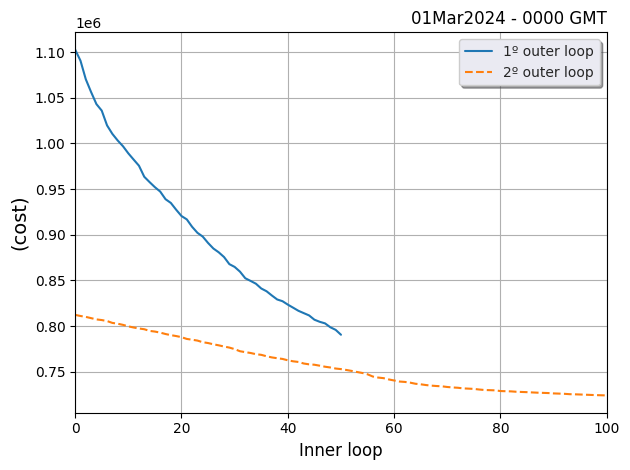

<Figure size 600x400 with 0 Axes>

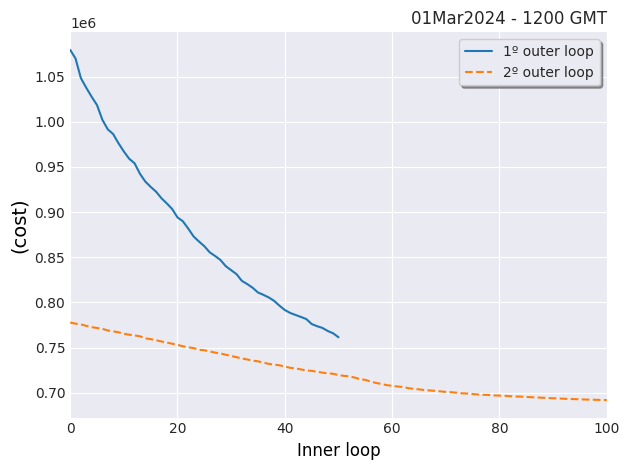

<Figure size 600x400 with 0 Axes>

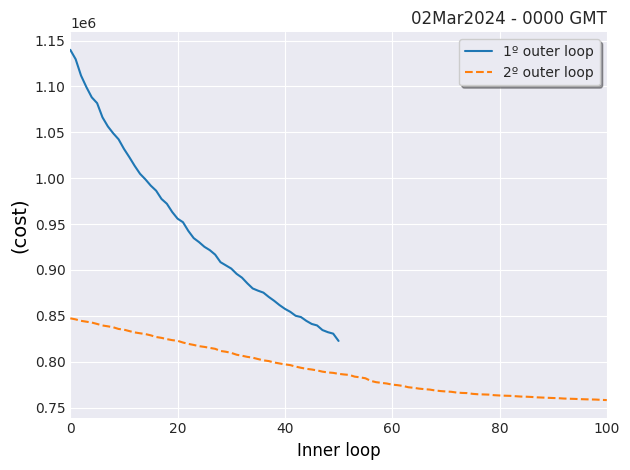

<Figure size 600x400 with 0 Axes>

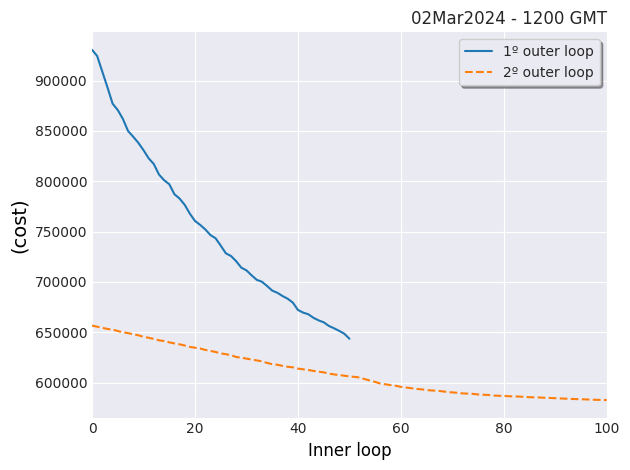

In [10]:
gd.plot_diag.fort220_plot(Self_1, dateIni=dateIni, 
                          dateFin=dateFin, 
                          nHour=nHour, 
                          Label='cost',
                          Flag=None,  
                          cost_gradient=True,  
                          Clean=None)

Agora, utiliza-se o dataframe `Self_2` para visualizar a contribuição da radiância (`Flag='26'` ou `Flag='32'`) na função custo (`J`) em relação aos *inner loops*. Neste caso é necessário atribuir `False` ao termo `cost_gradient`.

<Figure size 600x400 with 0 Axes>

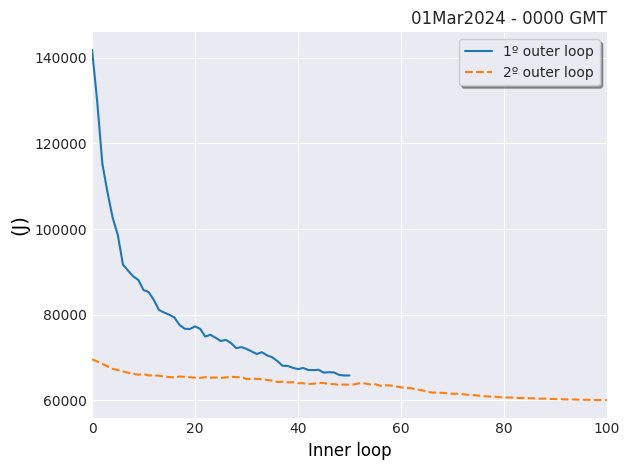

<Figure size 600x400 with 0 Axes>

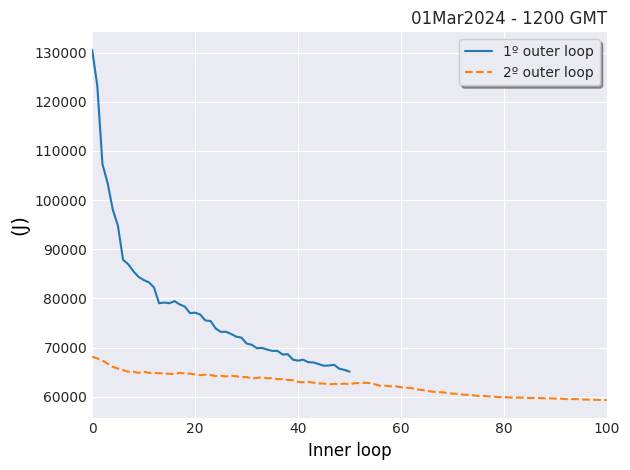

<Figure size 600x400 with 0 Axes>

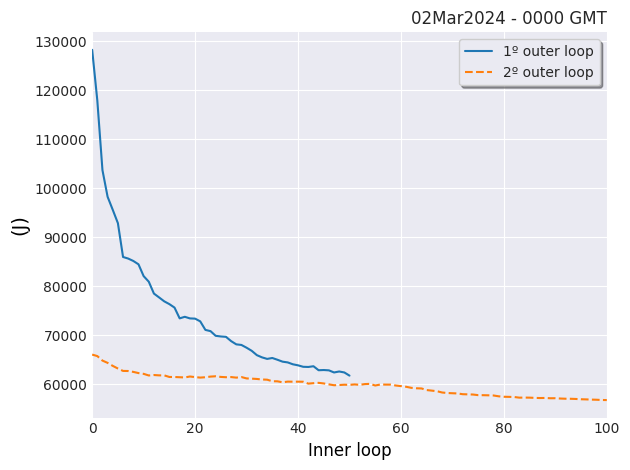

<Figure size 600x400 with 0 Axes>

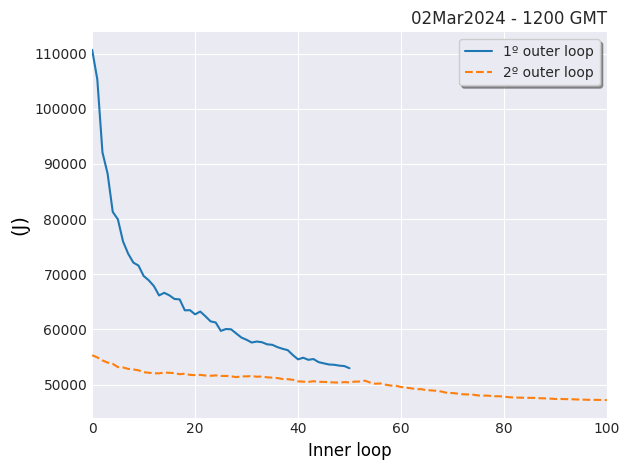

In [11]:
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.fort220_plot(Self_2, dateIni=dateIni, 
                          dateFin=dateFin, 
                          nHour=nHour, 
                          Label='J',
                          Flag=Flag,  
                          cost_gradient=False,  
                          Clean=None)

2. `fort220_plot_lines(self, dateIni=None, dateFin=None, nHour="06", Label=None, Flag=None, cost_gradient=False, vmin=None, vmax=None, Clean=None, **kwargs)` retorna uma figura com o gráfico da variável `Label` em função do *inner loop*, onde cada linha contínua refere-se aos dados do primeiro *outer loop* em difrentes datas e cada linha pontilhada identifica os dados obtidos no segundo *outer loop* no range dates fornecido. Como na função `fort220_plot`, o usuário precisa setar `cost_gradient=True` quando utilizado o arquivo `Self_1` e `cost_gradient=False` quando utilizado o arquivo `Self_2`.

<Figure size 1000x600 with 0 Axes>

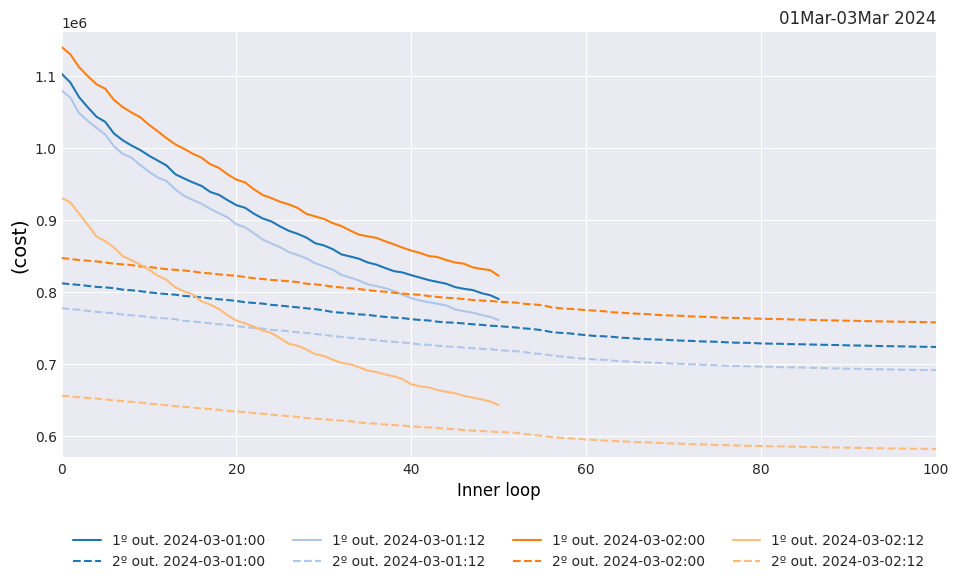

In [12]:
gd.plot_diag.fort220_plot_lines(Self_1, dateIni=dateIni, 
                                dateFin=dateFin, 
                                nHour=nHour, 
                                Label='cost', 
                                Flag=None, 
                                cost_gradient=True, 
                                vmin=None, 
                                vmax=None, 
                                Clean=None)

<Figure size 1000x600 with 0 Axes>

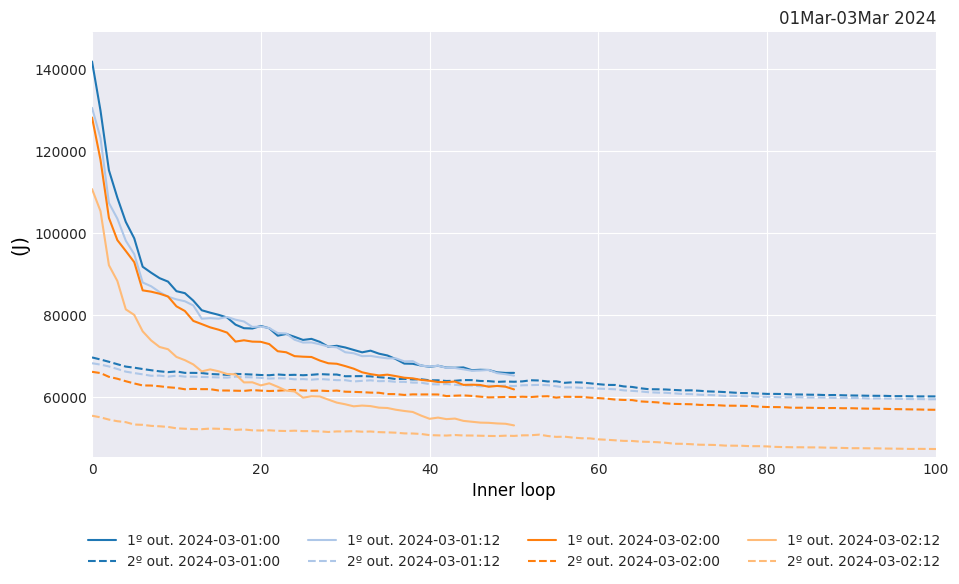

In [13]:
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.fort220_plot_lines(Self_2, dateIni=dateIni, 
                                dateFin=dateFin, 
                                nHour=nHour, 
                                Label='J', 
                                Flag=Flag, 
                                cost_gradient=False, 
                                vmin=None, 
                                vmax=None, 
                                Clean=None)

3. `fort220_time(self, dateIni=None, dateFin=None, nHour="06", Label=None, Flag=None, cost_gradient=False, Clean=None)` retorna uma figura com gráfico de linhas da variável `Label` em função do tempo (`date`) no primeiro e último *inner loop* de cada *outer loop*. Como na função `fort220_plot`, o usuário precisa setar `cost_gradient=True` quando utilizado o arquivo `Self_1` e `cost_gradient=False` quando utilizado o arquivo `Self_2`.

<Figure size 1000x400 with 0 Axes>

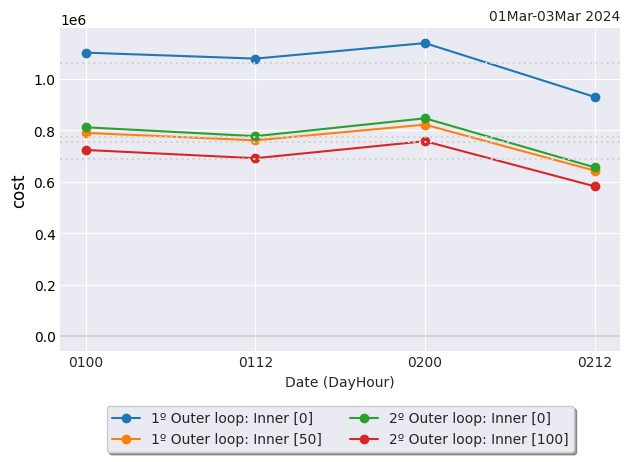

In [14]:
gd.plot_diag.fort220_time(Self_1, dateIni=dateIni, 
                          dateFin=dateFin, 
                          nHour=nHour, 
                          Label='cost',
                          Flag=None,  
                          cost_gradient=True, 
                          Clean=None)

<Figure size 1000x400 with 0 Axes>

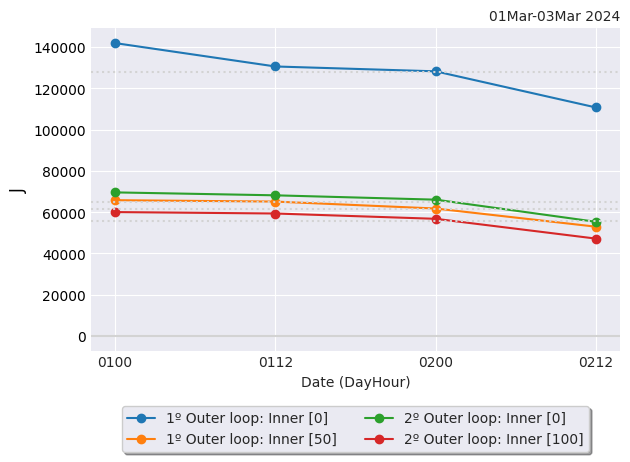

In [15]:
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.fort220_time(Self_2, dateIni=dateIni, 
                          dateFin=dateFin, 
                          nHour=nHour, 
                          Label='J',
                          Flag=Flag,  
                          cost_gradient=False, 
                          Clean=None)

4. `fort220_time_Obscontrib(self1, self2, dateIni=None, dateFin=None, nHour="06", Label=None, LabelObs=None, Flag=None, Clean=None)`

A função de custo total (`cost`) é a soma da lista `J` (lista de contribuições de cada observação). Esta função plota a taxa (DQ) da contribuição da observação `LabelObs` em relação à variável `Label`. O quociente DQ é calculado para cada loop externo.

`DQ = ( J_last - J_first )/( cost_last - cost_first )`

onde,

last --> valor no último loop interno

firs --> valor no primeiro loop interno

Se `Flag=None`, são plotados gráficos de barras, onde cada barra representa uma flag, e uma figura para cada data é retornada. Se Flag for um número, dois gráficos de séries temporais são retornados:

1º) Q = (J/cost)100 no primeiro e último loop interno de cada loop externo.

2º) DQ de cada loop externo.

+--------- DQ1 -----------+
[0.2436801236570976, 0.20572274515214684, 0.20939036035737232, 0.20113068303683387]

+--------- DQ2 -----------+
[0.10805668028767212, 0.10260844616362728, 0.1040919004199923, 0.10989754590565046]



<Figure size 1000x400 with 0 Axes>

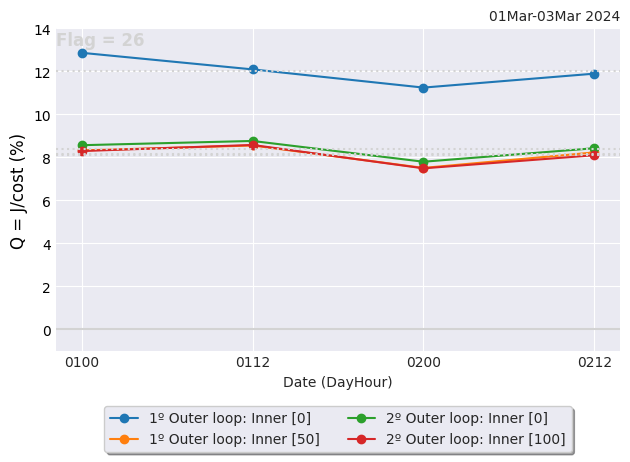

<Figure size 1000x400 with 0 Axes>

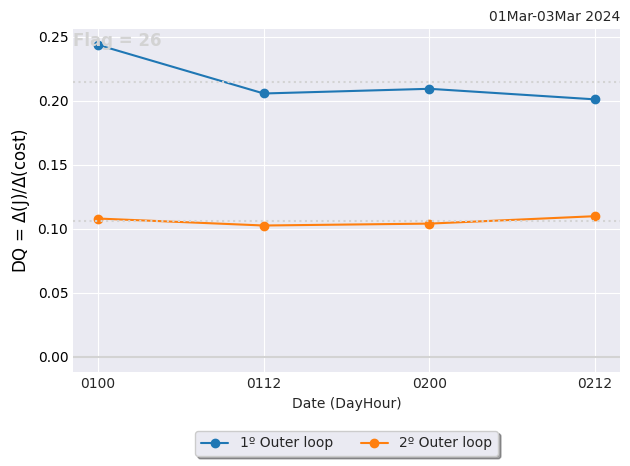

In [16]:
# Gráfico de barras de todas as Flags
# Flag = None

# Gráficos de linhas para uma Flag
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.fort220_time_Obscontrib(Self_1, Self_2, 
                                     dateIni=dateIni, 
                                     dateFin=dateFin, 
                                     nHour=nHour, 
                                     Label='cost', 
                                     LabelObs='J', 
                                     Flag=Flag, 
                                     Clean=None)

x_Flags =  [1.0, 3.0, 4.0, 5.0, 12.0, 13.0, 14.0, 15.0, 25.0, 26.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 12.0, 13.0, 14.0, 15.0, 25.0, 26.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 12.0, 13.0, 14.0, 15.0, 25.0, 26.0]
x_Flags =  [1.0, 3.0, 4.0, 5.0, 12.0, 13.0, 14.0, 15.0, 25.0, 26.0]
+--------- DQ1 -----------+
[-0.07898789808823044, -3.719444353586851e-06, -1.9592614297696512e-07, -0.00017332302063823287, 0.057287374652805555, 0.08453661417711522, 0.26617856175109833, 0.011550346573885163, 0.45848155628762693, 0.20113068303683387]

+--------- DQ2 -----------+
[-0.6495694749042975, -3.1874695101953837e-07, -2.3809256145691616e-06, -0.0006488557023635893, 0.05511095461462951, 0.12715933288251635, 0.3078900627862437, 0.033442319840796174, 1.0167208142493913, 0.10989754590565046]



<Figure size 800x600 with 0 Axes>

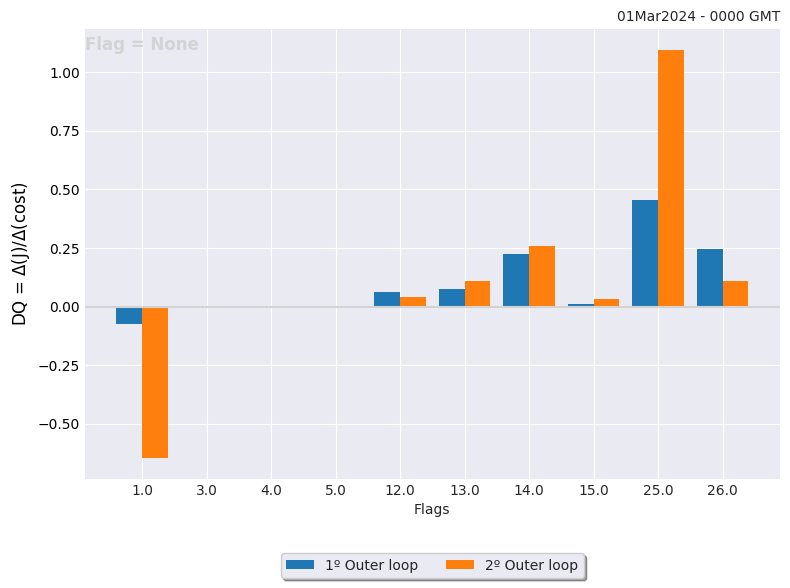

<Figure size 800x600 with 0 Axes>

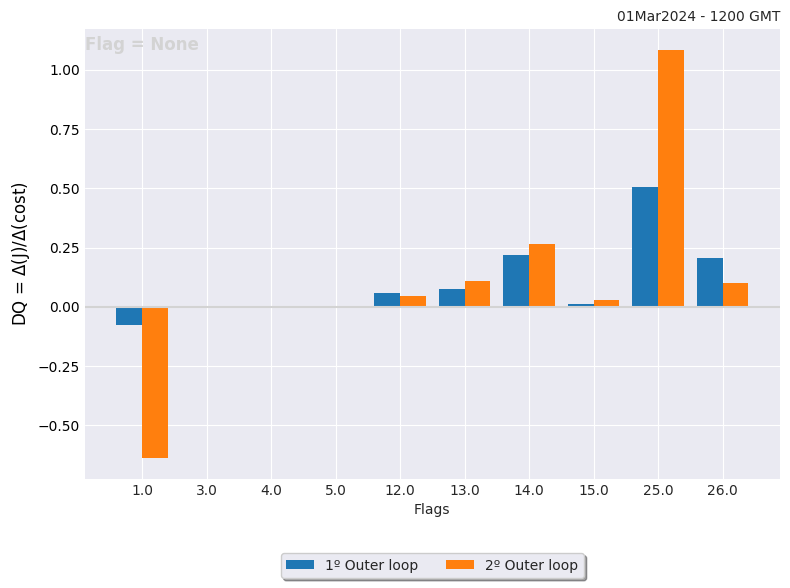

<Figure size 800x600 with 0 Axes>

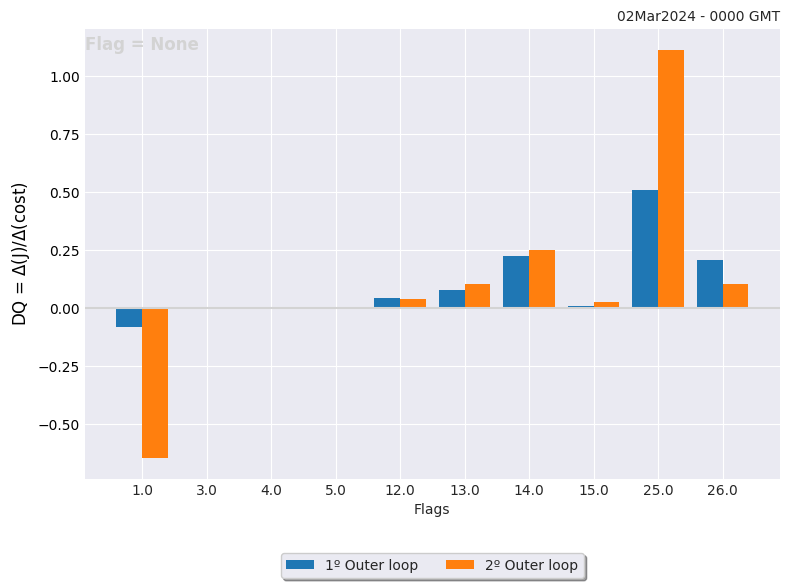

<Figure size 800x600 with 0 Axes>

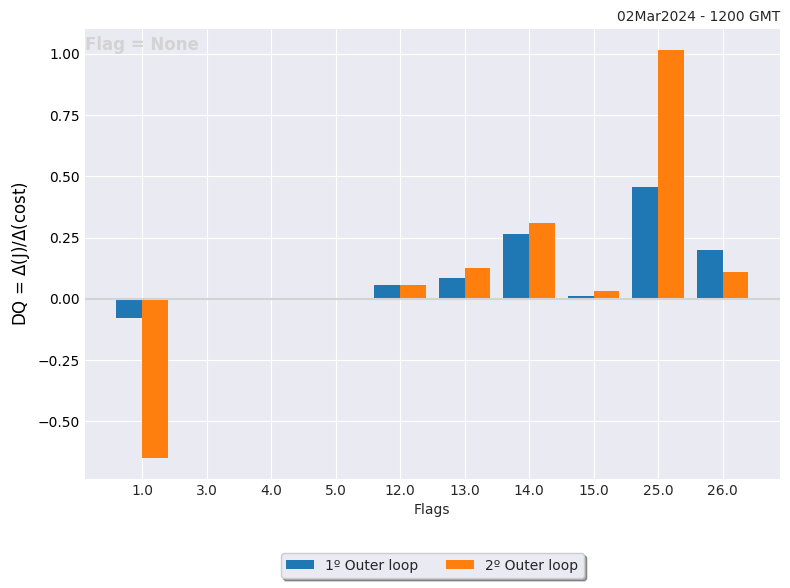

In [17]:
# Gráfico de barras de todas as Flags
Flag = None

gd.plot_diag.fort220_time_Obscontrib(Self_1, Self_2, 
                                     dateIni=dateIni, 
                                     dateFin=dateFin, 
                                     nHour=nHour, 
                                     Label='cost', 
                                     LabelObs='J', 
                                     Flag=Flag, 
                                     Clean=None)

5. `time_series_fort220(self, OuterLoop=1, Label=None, Flag=None, dateIni=None, dateFin=None, nHour="06", Clean=None)`

A função plota uma série temporal para dados do arquivo `Self_2` em diferentes flags dos termos de contribuição `J`, `b`, `c` ou de penalidade `EJ`. Um diagrama de Hovmoller é retornado se `Flag=None` ou se Flag for uma lista.

**Obs.:** considerar os nºs das flags no formato inteiro (`int`) (nesta função não utilizar o formato string para identificar a Flag). 


26 0

Outer Loop:  2  Label:  J
nloop =  100
 Preparing data for: 2024-03-01:00  - Flag:  26
nloop =  100
 Preparing data for: 2024-03-01:12  - Flag:  26
nloop =  100
 Preparing data for: 2024-03-02:00  - Flag:  26
nloop =  100
 Preparing data for: 2024-03-02:12  - Flag:  26


flags =  [26]
 Calculating for 2024-03-01:00
 Calculating for 2024-03-01:12
 Calculating for 2024-03-02:00
 Calculating for 2024-03-02:12


 Making Graphics...
 Done!



<Figure size 600x400 with 0 Axes>

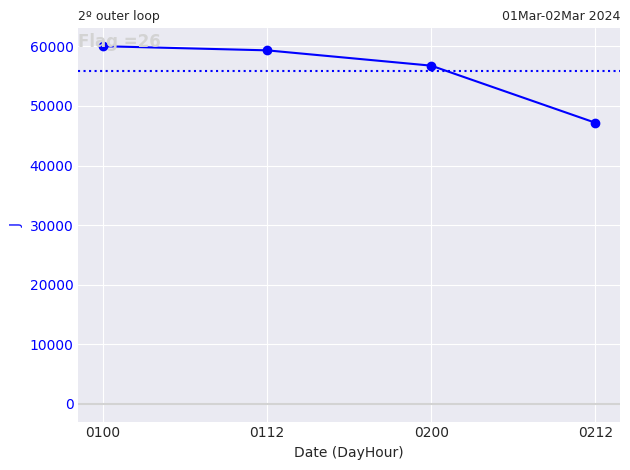

In [18]:
# indicar a flag como inteiro

#----- Flags list -----------#
# Flag = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]

#----- all Flags ------------#
# Flag = None

#----- number flag ----------#
if EXP19:
    Flag = 26
else:
    Flag = 32

gd.plot_diag.time_series_fort220(Self_2, OuterLoop=2, 
                                 Label='J', 
                                 Flag=Flag,  
                                 dateIni=dateIni, 
                                 dateFin=dateFin, 
                                 nHour=nHour, 
                                 Clean=False)


[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27] 1

Outer Loop:  2  Label:  J
nloop =  100
 Preparing data for: observation flags2024-03-01:00
 Flags:  [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]

nloop =  100
 Preparing data for: observation flags2024-03-01:12
 Flags:  [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]

nloop =  100
 Preparing data for: observation flags2024-03-02:00
 Flags:  [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]

nloop =  100
 Preparing data for: observation flags2024-03-02:12
 Flags:  [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]



flags =  [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]
 Calculating for 2024-03-01:00
 Calculating for 2024-03-01:12
 Calculating for 2024-03-02:00
 Calculating for 2024-03-02:12


 Making Graphics...
 Done!



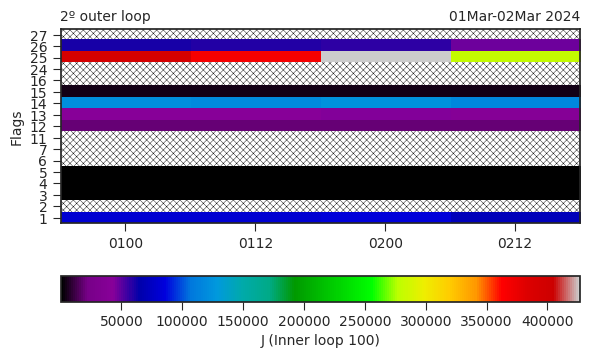

In [19]:
# indicar a flag como inteiro

#----- Flags list -----------#
# EXP19
Flag = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27]

#----- all Flags ------------#
# Flag = None

gd.plot_diag.time_series_fort220(Self_2, OuterLoop=2, 
                                 Label='J', 
                                 Flag=Flag,  
                                 dateIni=dateIni, 
                                 dateFin=dateFin, 
                                 nHour=nHour, 
                                 Clean=False)

6. `Mean_std_fort220(self, OuterLoop=None, cost_gradient=True, Label=None, Flag=None, dateIni=None, dateFin=None, nHour="06", Clean=None)`

Esta função plota um gráfico dos valores médios e dos desvios padrão da variável `Label` calculados no intervalo de tempo e para cada *inner loop*. No final a função retorna uma figura onde os pontos são os valores médios e o desvio padrão é representado na forma de uma barra vertical, indicando para cada *inner loop* a variabilidade do dado no intervalo de tempo.


zloops_def =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

Outer Loop:  None , Label:  grad , Flag:  None

OuterLoop =  None : nloop1 =  50  nloop2 =  100
 Preparing data for: 2024-03-01:00
 Preparing data for: 2024-03-01:12
 Preparing data for: 2024-03-02:00
 Preparing data for: 2024-03-02:12

levs DayHour =  ['0100', '0112', '0200', '0212']
len levs DayHour =  4

Outer Loop 1 Calculating for inner loop 0
Outer Loop 1 Calculating for inner loop 1
Outer Loop 1 Calculating for inner loop 2
Outer Loop 1 Calculating for inner loop 3
Outer Loop 1 Calculating for inner loop 4
Outer Loop 1 Calculating for inner loop 5
Outer Loop 1 Calculating fo

<Figure size 1000x600 with 0 Axes>

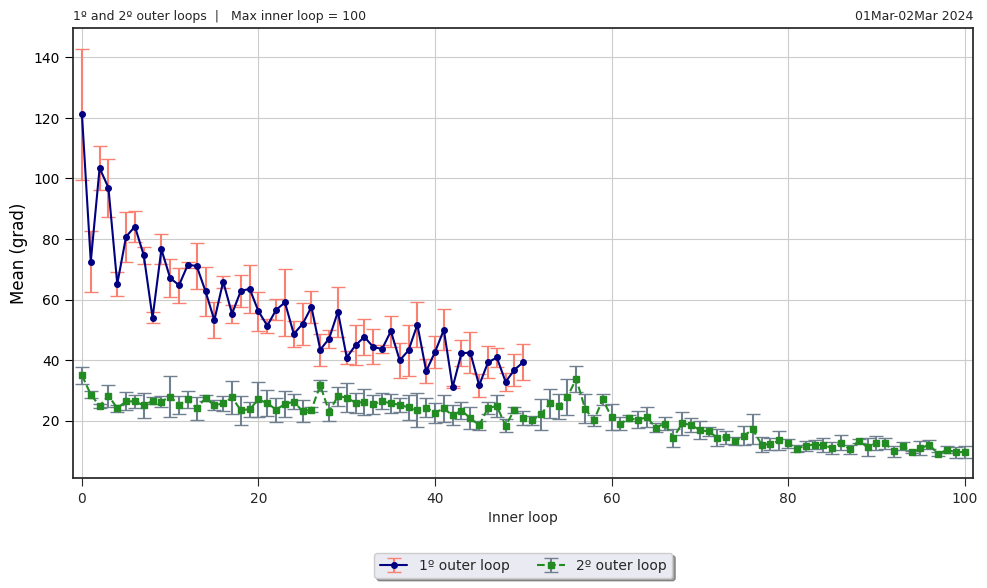

In [20]:
gd.plot_diag.Mean_std_fort220(Self_1, OuterLoop=None, 
                              cost_gradient=True, 
                              Label='grad', 
                              Flag=None, 
                              dateIni=dateIni, 
                              dateFin=dateFin, 
                              nHour=nHour, 
                              Clean=False)


zloops_def =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

Outer Loop:  2 , Label:  J , Flag:  26

OuterLoop =  2 : nloop =  100  nloop2 =  0
 Preparing data for: 2024-03-01:00
 Preparing data for: 2024-03-01:12
 Preparing data for: 2024-03-02:00
 Preparing data for: 2024-03-02:12

levs DayHour =  ['0100', '0112', '0200', '0212']
len levs DayHour =  4

Outer Loop 2 Calculating for inner loop 0
Outer Loop 2 Calculating for inner loop 1
Outer Loop 2 Calculating for inner loop 2
Outer Loop 2 Calculating for inner loop 3
Outer Loop 2 Calculating for inner loop 4
Outer Loop 2 Calculating for inner loop 5
Outer Loop 2 Calculating for inner loop 

<Figure size 1000x600 with 0 Axes>

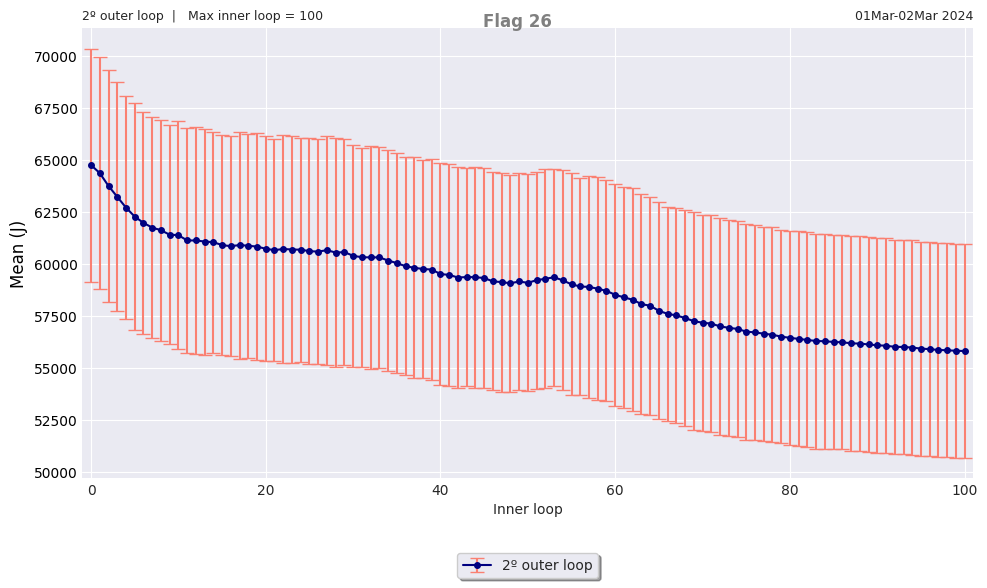

In [21]:
Label = 'J'
if EXP19:
    Flag = '26'
else:
    Flag = '32'

gd.plot_diag.Mean_std_fort220(Self_2, OuterLoop=2, 
                              cost_gradient=False, 
                              Label=Label, 
                              Flag=Flag, 
                              dateIni=dateIni, 
                              dateFin=dateFin, 
                              nHour=nHour, 
                              Clean=False)


Caso o usuário queira gerar um GiF animado com as figuras geradas pela função `fort220_plot`, basta adaptar o caminho do diretório.

In [22]:
from PIL import Image
import os

imagens = []
path = "/home/radiancia/DiagRadi-V2_issue45/notebooks/"

Label='J'

imagens, frame_one = [], []
for i in range(len(dates)):
    tidx = i
    datefmt = dates[tidx]
    
    new = Image.open(path + '/' + 'Fort220_'+str(Label) +'_'+datefmt+'.png')
    imagens.append(new)
    
# Salvar imagem no formato gif contendo todas as imagens do 
frame_one = imagens[0]
frame_one.save("GiF-Fort220_"+str(Label) +"_"+datefmt+".gif", save_all=True, 
                append_images=imagens, duration=1000, loop=0)

print('Gif criado')
print('')

Gif criado

